Load libaries need for time series forcasting

In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

Load dataset
The data describes exchange rates for the Euro to US dollars

In [2]:
df = pd.read_csv('BOE-XUDLERD.csv')
df.head()

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608


Convert DataFrame to time series with daily frequency

In [3]:
#Using Date data as DataFrane index/label
df['Date'] = pd.to_datetime(df['Date'])
indexed_df = df.set_index('Date')

ts = indexed_df['Value']
ts.head(5)
indexed_df.head(5)

,Value
Date,
2017-11-09,0.8603
2017-11-08,0.8631
2017-11-07,0.8639
2017-11-06,0.8631
2017-11-03,0.8608


c:\users\thien\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


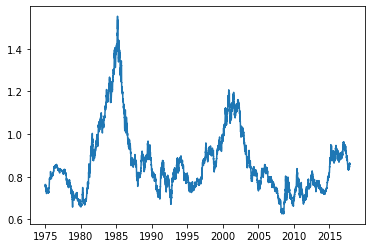

In [4]:
#Visualize this time series to see how Euro is trending again US dollar 
plt.plot(ts)

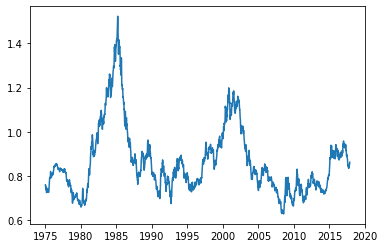

In [5]:
#Resample the data by Week. 
#We will use this sample to predict the Euro exchange rates against US dollars
ts_week = ts.resample('W').mean()
plt.plot(ts_week)

Date
1975-01-31    0.749132
1975-02-28    0.737910
1975-03-31    0.730337
1975-04-30    0.741623
1975-05-31    0.731286
Freq: M, Name: Value, dtype: float64

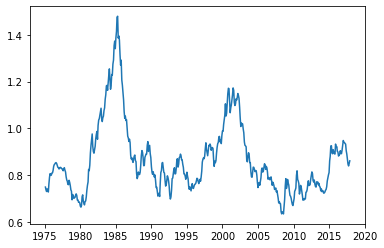

In [6]:
#Resample the data by Month. 
ts_month = ts.resample('M').mean()
plt.plot(ts_month)
ts_month.head()

Date
1975-12-31    0.766268
1976-12-31    0.837672
1977-12-31    0.823871
1978-12-31    0.747492
1979-12-31    0.697025
Freq: A-DEC, Name: Value, dtype: float64

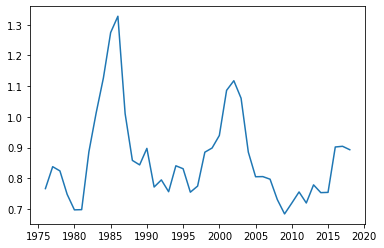

In [7]:
#Resample the data by Year. 
ts_year = ts.resample('Y').mean()
plt.plot(ts_year)
ts_year.head()

In [31]:
# This use for visualize testing stationarity purpose
# window is number of lags
# However, we might not always be able to make such visual inferences

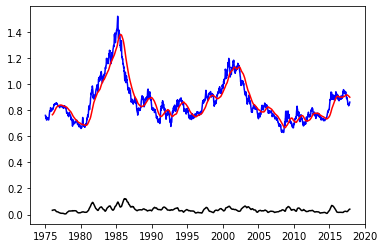

In [8]:
rolmean = ts_week.rolling(window=52,center=False).mean() 
rolstd = ts_week.rolling(window=52,center=False).std()
plt.plot(ts_week, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.show()

# Applying Dickey-Fuller test:
- Because the test statistic is more than 5% critical value (-2.076341 < -2.862835) 
- p-value is larger than 0.05 
- The moving average is not constant over time and null hypothesis of the Dickey-Fuller test cannot be rejected.
- This shows that this weekly time series is not stationary

In [9]:
#Applying Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_week, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value (1%)              -3.433281
Critical Value (5%)              -2.862835
Critical Value (10%)             -2.567459
dtype: float64


# Repair the time series before applying ARIMA
We need to transform the time series into a stationary time series

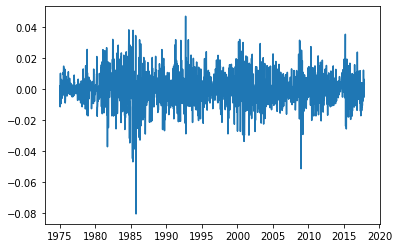

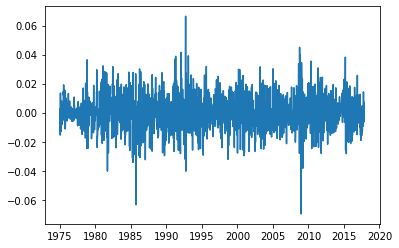

In [10]:
#Applying differencing to stationarize the data
ts_week_diff = ts_week - ts_week.shift()
plt.plot(ts_week_diff)
plt.show()

#Perform log transformation prior differencing for better results
ts_week_log = np.log(ts_week) #log make normal distrubition (time usually right skew)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)



# Confirm with Dicky Fuller test
- The test statistic is less than 1% critical value (-36.590004 < -3.433279) shows that this your time series is stationary with 99% confidence. 
- Now we can apply statistical model ARIMA

Results of Dickey-Fuller Test:
Test Statistic                  -36.590004
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2235.000000
Critical Value (1%)              -3.433279
Critical Value (5%)              -2.862834
Critical Value (10%)             -2.567459
dtype: float64


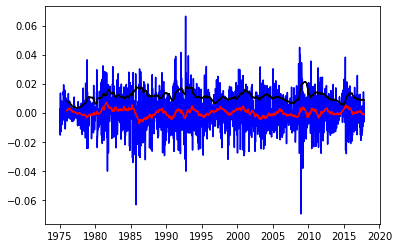

In [11]:
# Drop na data
ts_week_log_diff.dropna(inplace=True)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_week_log_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

rolmean = ts_week_log_diff.rolling(window=52,center=False).mean() 
rolstd = ts_week_log_diff.rolling(window=52,center=False).std()
plt.plot(ts_week_log_diff, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.show()

# Determine p,d, and q paramater of ARIMA model using ACF and PACF


In [12]:
#ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

c:\users\thien\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

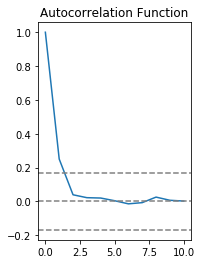

In [13]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

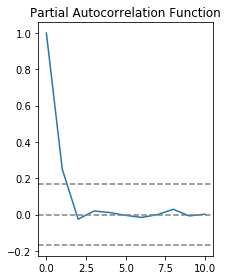

In [14]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Observer from the plots:
- p: The lag value where the PACF cuts off (drops to 0) for the first time. p = 2
- q: The lag value where the ACF charts crosses the upper confidence interval for the first time. q = 1
- Optimal model should be ARIMA(2,1,1)

Text(0.5, 1.0, 'RSS: 0.2806')

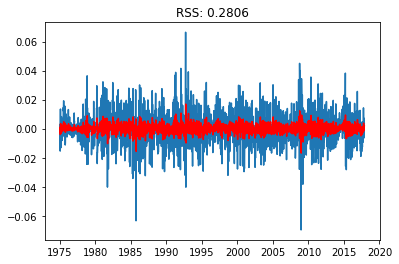

In [15]:
model = ARIMA(ts_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 16 Jul 2019   AIC                         -13731.202
Time:                        13:58:42   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.509e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

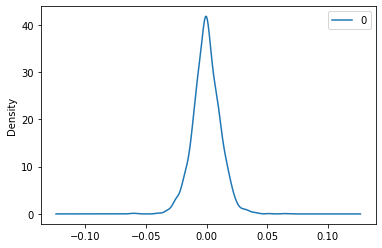

In [16]:
# Print the ARIMA result
print(results_ARIMA.summary())

# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [17]:
# Make prediction
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64

# Scaling the prediction
Scale them back to original scale
- Remove the differencing
- Take the exponent to restore the prediction back to original scale

c:\users\thien\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0.5, 1.0, 'RMSE: 0.1353')

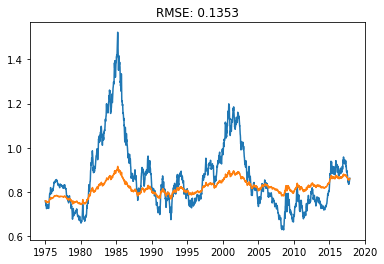

In [18]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.ix[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
# plt.plot(ts_week_log)
# plt.plot(predictions_ARIMA_log)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

# Split the data to training/testing set

In [19]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

In [21]:

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...




c:\users\thien\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\thien\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\thien\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\thien\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predicted=0.860622, expected=0.862600


In [22]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.000043


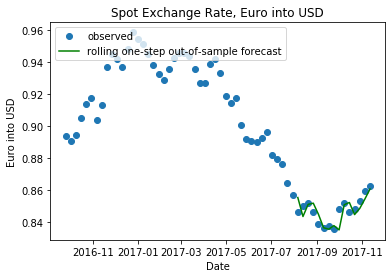

In [23]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')